# **Please note you need a GPU with at least 24GB memory to test this 3D turbulence generation**

# Imports

In [9]:
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [10]:
import torch
import numpy as np
from functools import partial
import sys
sys.path.append("../../../..")
from ConditionalDiffusionGeneration.src.guided_diffusion.unet import create_model
from ConditionalDiffusionGeneration.src.guided_diffusion.condition_methods import get_conditioning_method
from ConditionalDiffusionGeneration.src.guided_diffusion.measurements import get_noise, get_operator
from ConditionalDiffusionGeneration.src.guided_diffusion.gaussian_diffusion import create_sampler
from ConditionalNeuralField.cnf.inference_function import ReconstructFrame, decoder
from einops import rearrange

In [11]:
if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = "cpu"

device = torch.device(dev)

In [12]:
torch.manual_seed(42)
np.random.seed(42)

# Conditioning Data Loader

In [13]:
no_of_sensors = 10 #1,10,100,1000

In [14]:
true_measurement = torch.from_numpy(np.load(f'input/random_sensor/{no_of_sensors}/measures.npy')).to(device)

In [15]:
true_measurement.shape

torch.Size([384, 10, 3])

# Load trained unconditional model

In [16]:
u_net_model = create_model(image_size= 384,
                           num_channels= 128,
                           num_res_blocks= 2,
                           channel_mult = "1, 1, 2, 2, 4, 4",
                           num_heads=4,
                           num_head_channels=64,
                           attention_resolutions="32,16,8",
                           model_path='./input/diff_model/ema_0.9999_400000.pt'
                        );

u_net_model.to(device);
u_net_model.eval();

Got exception: [Errno 2] No such file or directory: './input/diff_model/ema_0.9999_400000.pt' / Randomly initialize


/Users/minghan/Library/CloudStorage/GoogleDrive-john.chuicandoit@gmail.com/My Drive/CoNFiLD/ConditionalDiffusionGeneration/inference_scripts/Case4/random_sensor/../../../../ConditionalDiffusionGeneration/src/guided_diffusion/unet.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full cont

# Operator and Noise

In [9]:
operator =  get_operator(device=device, name='case4',
                         coords_path=f'input/random_sensor/{no_of_sensors}/coords.npy',\
                         max_val_path="input/data_scale/data_max.npy",\
                         min_val_path="input/data_scale/data_min.npy",\
                         normalizer_params_path="input/cnf_model/Hirachical2-11-11_normalizer_params.pt",\
                         ckpt_path="input/cnf_model/checkpoint_20000.pt",
                         batch_size=384)

/Users/minghan/Library/CloudStorage/GoogleDrive-john.chuicandoit@gmail.com/My Drive/CoNFiLD/ConditionalDiffusionGeneration/inference_scripts/Case4/random_sensor/../../../../ConditionalDiffusionGeneration/src/guided_diffusion/measurements.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have 

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
# Load the operator from the saved file
operator = torch.load('/Users/minghan/Desktop/output_files/operator.pt', map_location=device)
operator.to(device)  # Make sure to transfer it to the correct device (GPU/CPU)

/var/folders/bc/tkxqx5c57fgcftsfpjb5zk8c0000gn/T/ipykernel_44817/3983872062.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  operator = torch.load('operator.pt', map_loca

FileNotFoundError: [Errno 2] No such file or directory: 'operator.pt'

In [10]:
noiser = get_noise(sigma=0.0, name='gaussian')

## For masking in time

In [11]:
# start, stop, step = 0, 257, 5
mask = torch.ones_like(true_measurement, device=device)
# mask[start:stop:step] = 1

# Conditioning Method

In [12]:
cond_method = get_conditioning_method(operator=operator, noiser=noiser, name='ps', scale=1.)
measurement_cond_fn = partial(cond_method.conditioning)

NameError: name 'operator' is not defined

# Sampler

In [17]:
sampler = create_sampler(sampler='ddpm',
                         steps=1000,
                         noise_schedule="cosine",
                         model_mean_type="epsilon",
                         model_var_type="fixed_large",
                         dynamic_threshold=False,
                         clip_denoised=True,
                         rescale_timesteps=False,
                         timestep_respacing="")

sample_fn = partial(sampler.p_sample_loop, model=u_net_model, measurement_cond_fn=measurement_cond_fn)

NameError: name 'measurement_cond_fn' is not defined

## Generate Samples

In [18]:
no_of_samples = 10
time_length = 384
latent_size = 384

In [19]:
x_start = torch.randn(no_of_samples, 1, time_length, latent_size, device=device)
samples = [sample_fn(x_start=x_start[i:i+1], measurement=mask*true_measurement, record=False, save_root=None) for i in range(x_start.shape[0])]

NameError: name 'sample_fn' is not defined

In [14]:
try:
    samples = torch.load(
        '/Users/minghan/Library/CloudStorage/GoogleDrive-john.chuicandoit@gmail.com/My Drive/CoNFiLD/ConditionalDiffusionGeneration/inference_scripts/Case4/random_sensor/samples.pth',
        map_location=torch.device('cpu'),
        weights_only=True  # Change this based on your need
    )
    print("Data loaded successfully.")
except Exception as e:
    print(f"Error loading the file: {e}")

Data loaded successfully.


In [15]:
gen_latents = torch.cat(samples)
gen_latents = operator._unnorm(gen_latents)
gen_latents = gen_latents[:,0]

NameError: name 'operator' is not defined

In [21]:
# Load gen_fields
gen_fields = torch.load(f"/Users/minghan/Desktop/output_files/gen_fields.pt", map_location=device)  # Ensure it's loaded to the correct device

/var/folders/bc/tkxqx5c57fgcftsfpjb5zk8c0000gn/T/ipykernel_50122/4222755778.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_fields = torch.load(f"/Users/minghan/Desk

# Decoding latents to flow fields

In [22]:
info = np.load("input/cnf_model/infos.npz")
coords = torch.tensor(np.load("input/cnf_model/coords.npy"), device=device, dtype=torch.float32)

In [23]:
xnorm  = operator.x_normalizer
ynorm  = operator.y_normalizer
model = operator.model
gen_latents_cnf_input = rearrange(gen_latents, "s t l -> (s t) l")

NameError: name 'operator' is not defined

In [7]:
gen_fields = decoder(coords, gen_latents_cnf_input, model, xnorm, ynorm, batch_size=16, device=device)
gen_fields = rearrange(gen_fields, "(s t) co c -> s t co c", t=time_length)

NameError: name 'decoder' is not defined

# Post processing the flow fields for visualization

In [24]:
pred_data_list = []
for ss in range(no_of_samples):
    for kk in range(time_length):
        pred_data = gen_fields[ss, kk].cpu().numpy()
        pred_data = ReconstructFrame(pred_data, mask=info['Mask'], shape=info['reduced_shape'], fill_value = 0.)# <Nx,Ny,Nz, cout>
        pred_data_list.append(pred_data)

### The generated 3D flow fields

* saved with shape [samples, time, x, y, z, vars].
    * vars includes 3 velocity components, u, v, w.

In [5]:
pred_data_list = rearrange(np.stack(pred_data_list), "(s t) x y z c -> s t x y z c", t=time_length)

NameError: name 'rearrange' is not defined

# Comparison of sensor plots

In [25]:
from numpy.random import default_rng
import matplotlib.pyplot as plt
import pylab
params = {'legend.fontsize': 25,'axes.labelsize': 25,'axes.titlesize':25,'xtick.labelsize':25,'ytick.labelsize':25}
pylab.rcParams.update(params)

In [26]:
rng = default_rng(seed=56)
train_probes = rng.choice(gen_fields.shape[2], size=no_of_sensors, replace=False)

In [27]:
gen_Umag = torch.sqrt((gen_fields**2).sum(axis=-1)).detach().cpu()

In [28]:
meand, stdd = torch.mean(gen_Umag, dim=0), torch.std(gen_Umag, dim=0)

In [29]:
train_data_Umag = torch.sqrt((true_measurement**2).sum(axis=-1)).detach().cpu()

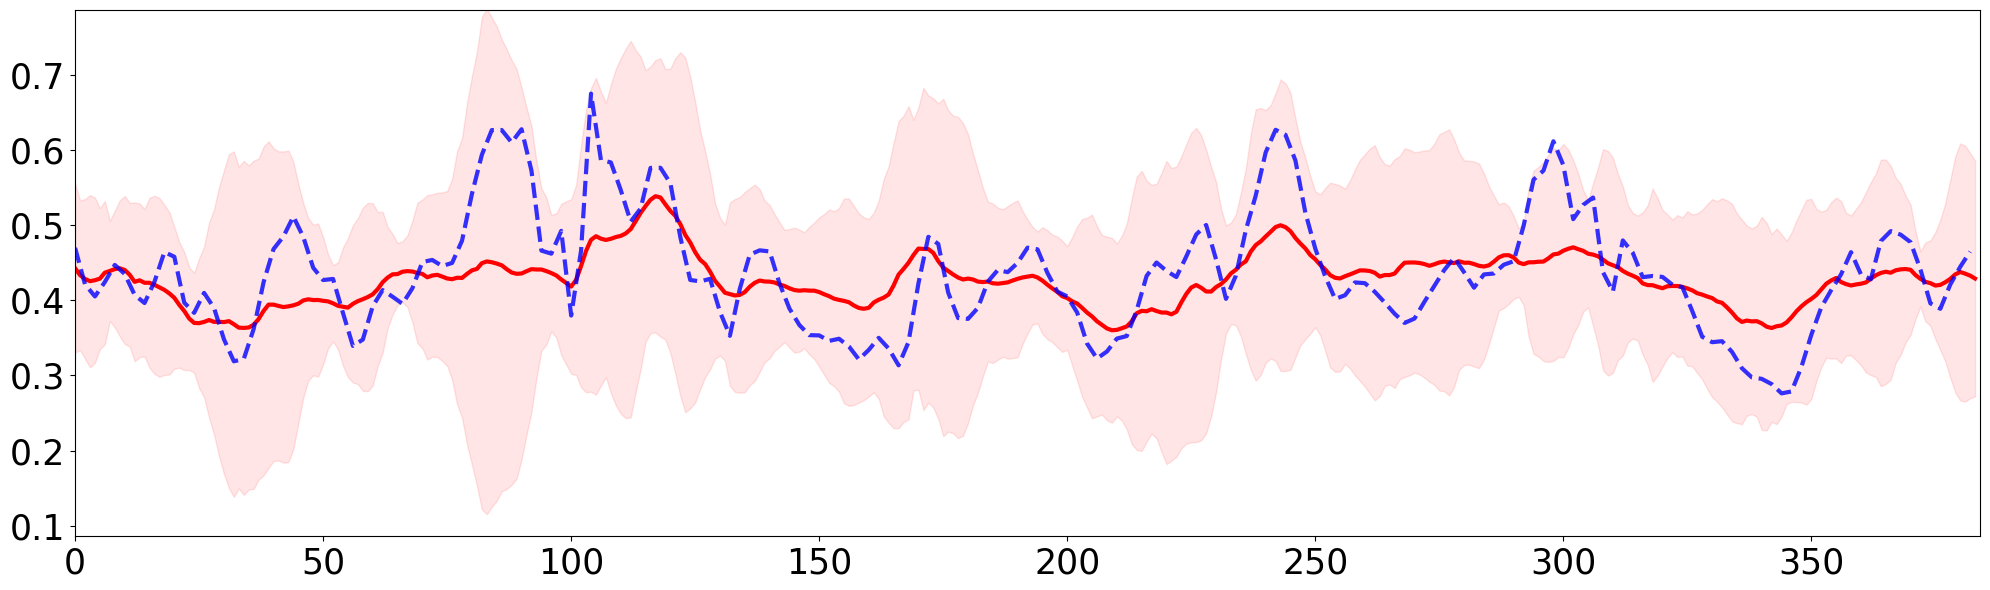

In [32]:
for probe in train_probes[:1]:
    range_ = 0.7
    scale = 3
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,6))
    for _ in range(1):
        uncer_up_lim, uncer_down_lim = meand + scale*stdd, meand - scale*stdd
        axes.fill_between(np.arange(384), (uncer_up_lim)[:, probe], (uncer_down_lim)[:, probe], color='red', alpha=0.1)
        axes.plot(meand[:,  probe], color='red', linewidth=3)
        axes.plot(np.arange(384)[::2], train_data_Umag[::2, 0], "--",linewidth=3, alpha=0.8, color='blue')
        mean_gt_Umag = train_data_Umag[:, 0].mean()
        axes.set_ylim([mean_gt_Umag - range_/2 ,mean_gt_Umag + range_/2])
        axes.set_xlim([0,384])
    fig.tight_layout()
    plt.show()

dashed blue line represents the sensor measurements, red line is the mean of all generated samples at the sensor location. The shaded area is the uncertainty corresponding to $3 \sigma$.